In [115]:
import os
import cv2
import matplotlib.pyplot as plt
import torch
import numpy as np
from scipy.spatial.transform import Rotation
import quaternion
from scipy.interpolate import griddata

# from mpl_toolkits import mplot3d

# %matplotlib notebook

In [159]:
def get_color(folder, frame_index, side, do_flip):
    if side == 'r':
        side = 'right'
    else:
        side = 'left'

    color_path = os.path.join(folder, "0", f"{side}_rgb", str(frame_index) + ".jpg")
    color = cv2.imread(color_path, -1)

    if do_flip:
        color = color.transpose(pil.FLIP_LEFT_RIGHT)

    return color

def get_depth(folder, frame_index, side, do_flip):
    if side == 'r':
        side = 'right'
    else:
        side = 'left'

    depth_path = os.path.join(folder, "0", f"{side}_depth", str(frame_index) + ".png")
    depth = cv2.imread(depth_path, -1).astype(np.float32) * 10 / 65535

    if do_flip:
        depth = np.fliplr(depth)

    return depth

def get_pose(folder, frame_index, side, do_flip):
    # Refer to registration_test notebook.
    
    cam_to_agent = np.eye(4)
    cam_to_agent[1,1] = -1  # Flip the y-axis of the point-cloud to be pointing upwards
    cam_to_agent[2,2] = -1  # Flip the z-axis of the point-cloud to follow right-handed coordinate system.
    
    if side == 'r':
        cam_to_agent[:3, 3] = np.array([baseline/2, cam_height, 0])
    else:
        cam_to_agent[:3, 3] = np.array([-baseline/2, cam_height, 0])

    pose_path = os.path.join(folder, "0", "pose", str(frame_index) + ".npy")
    agent_pose = np.load(pose_path, allow_pickle=True).item()

    rot = Rotation.from_quat([agent_pose['rotation'].x, agent_pose['rotation'].y, 
                            agent_pose['rotation'].z, agent_pose['rotation'].w])
    R = np.eye(4)
    R[:3, :3] = rot.as_matrix()

    T = np.eye(4)
    T[:3, 3] = agent_pose['position']
    
    M = (T @ R @ cam_to_agent).astype(np.float32)

    # The images will already be locally flipped. 
    # We need to only flip the camera's global x-coordinate.
    # Refer to registration_notebook.
    M[0,3] *= (1 - 2*do_flip)

    return M

In [160]:
def camera_intrinsic_transform(f_x, c_x, f_y, c_y):
    camera_intrinsics = np.zeros((3,4))
    camera_intrinsics[0][0] = f_x
    camera_intrinsics[1][1] = f_y
    camera_intrinsics[2][2] = 1
    camera_intrinsics[0][2] = c_x
    camera_intrinsics[1][2] = c_y
    
    return camera_intrinsics

def img_to_rect( u, v, depth_rect, P2):
    
    cu = P2[0, 2]
    cv = P2[1, 2]
    fu = P2[0, 0]
    fv = P2[1, 1]

    x = ((u - cu) * depth_rect) / fu
    y = ((v - cv) * depth_rect) / fv
    pts_rect = np.concatenate((x.reshape(-1, 1), y.reshape(-1, 1), depth_rect.reshape(-1, 1)), axis=1)
    return pts_rect

def img_to_lid(depth_map, cam_mat, label=None):

    x_range = np.arange(0, depth_map.shape[1])
    y_range = np.arange(0, depth_map.shape[0])
    x_idxs, y_idxs = np.meshgrid(x_range, y_range)
    x_idxs, y_idxs = x_idxs.reshape(-1), y_idxs.reshape(-1)


    depth = depth_map[y_idxs, x_idxs]
    pts_rect = img_to_rect(x_idxs, y_idxs, depth, cam_mat)
    
    if label is not None:
        label_intensity = label[y_idxs, x_idxs]
        filt = label_intensity == 2
        pts_rect = pts_rect[filt]

    return pts_rect

In [161]:
baseline = 0.2
cam_height = 1.0
K = camera_intrinsic_transform(f_x=320, c_x=320, f_y=320, c_y=240)

data_dir = '/shanta_tmp/habitat_data/HabitatVal/'
os.listdir(data_dir)

['oLBMNvg9in8',
 '2azQ1b91cZZ',
 'zsNo4HB9uLZ',
 'EU6Fwq7SyZv',
 'x8F5xyUWy9e',
 'Z6MFQCViBuw',
 'oLBMNvg9in8.zip',
 'QUCTc6BB5sX',
 'pLe4wQe7qrG',
 'X7HyMhZNoso',
 '8194nk5LbLH',
 'TbHJrupSAjP']

In [162]:
scene = 'oLBMNvg9in8'
scene_dir = os.path.join(data_dir, scene)

## Temporal Stereo

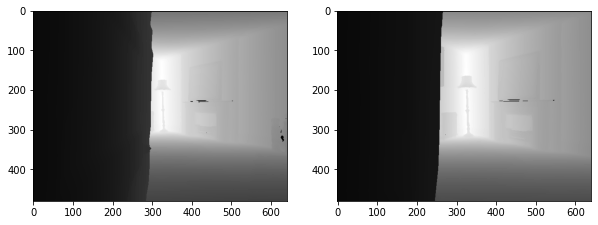

In [222]:
idx_s = 100 # source
idx_t = 103 # target

color_s = get_color(scene_dir, idx_s, 'l', False)
color_t = get_color(scene_dir, idx_t, 'l', False)

depth_s = get_depth(scene_dir, idx_s, 'l', False)
depth_t = get_depth(scene_dir, idx_t, 'l', False)

pose_s = get_pose(scene_dir, idx_s, 'l', False)
pose_t = get_pose(scene_dir, idx_t, 'l', False)
T = np.linalg.inv(pose_s) @ pose_t

fig, ax = plt.subplots(ncols=2, figsize=(10,5))
ax[0].imshow(depth_s, 'gray')
ax[1].imshow(depth_t, 'gray')

plt.show()

## Spatial Stereo

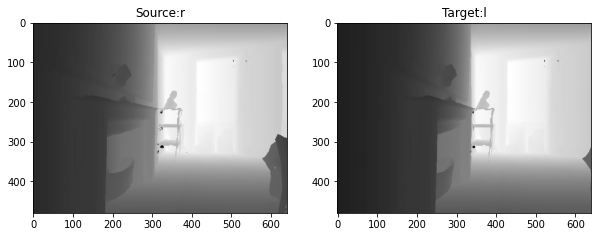

In [211]:
idx = 180
src_side = 'r'
tgt_side = 'l'

color_s = get_color(scene_dir, idx, src_side, False)
color_t = get_color(scene_dir, idx, tgt_side, False)

depth_s = get_depth(scene_dir, idx, src_side, False)
depth_t = get_depth(scene_dir, idx, tgt_side, False)

 # target to source Transformation matrix
T = np.eye(4)
T[0, 3] = -baseline if tgt_side == 'l' else baseline

fig, ax = plt.subplots(ncols=2, figsize=(10,5))
ax[0].imshow(depth_s, 'gray')
ax[0].set_title(f'Source:{src_side}')

ax[1].imshow(depth_t, 'gray')
ax[1].set_title(f'Target:{tgt_side}')

plt.show()

## Reconstruction logic

The idea to reconstruct the target view using source's color map and target's predicted depth map.
To do so, we first reconstruct the point cloud $pc$_$t$ using the predicted depth map $D$ for the target frame using the inverse of the camera intrinsics matrix i.e. $K$<sup>-1</sup>

Then we warp it to the source camera frame using relative transformation matrix $T$<sub>t->s</sub> and the camera intrinsics matrix $K$. 

We then use bilinear interpolation based sampling to fetch the colors from the source color map for these warped coordinates to reconstruct the target view.

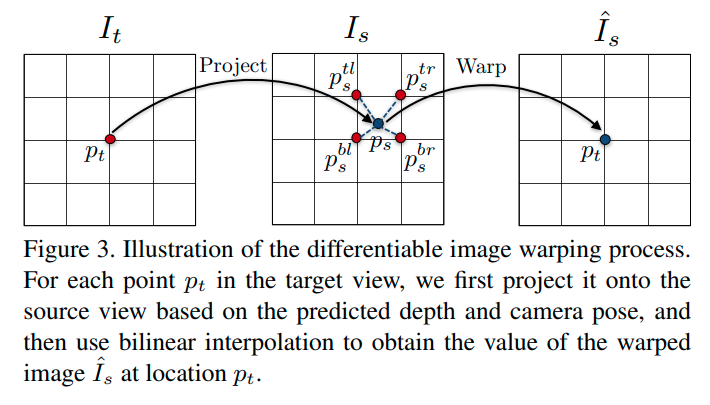

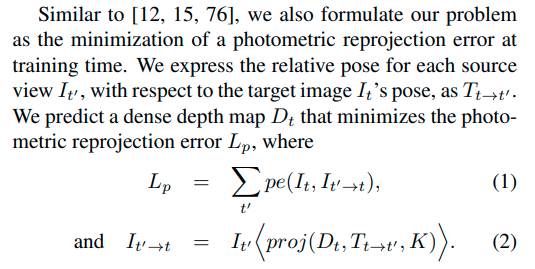

In [223]:
## Based on BackprojectDepth module of monodepth2

inv_K = np.linalg.inv(K[:3,:3])

h, w = depth_t.shape

img_rect = np.concatenate([np.indices((w, h)), np.ones((1, w, h))], axis=0)

pc_t = (inv_K @ img_rect.reshape((3, -1))).reshape((3, w, h))
pc_t = pc_t.transpose((0,2,1)) * depth_t
pc_t = pc_t.reshape((3, -1))

pc_t = np.concatenate([pc_t, np.ones((1, h*w))], axis=0)

## or just use
# pc_t = img_to_lid(depth_t, K)

In [224]:
## Based on Project3D module of monodepth2

P = (K @ T)[:3,:] # Projection matrix to warp pc_t to camera frame of source.

cam_points = P @ pc_t

cam_points = cam_points[:2,:]/(np.expand_dims(cam_points[2,:], axis=0) + 1e-6)
cam_points = cam_points.reshape((2, h, w)).transpose((1,2,0))


# For torch grid_sample, we need to normalize the points to fall in range of (-1,1)
# But this is not needed for scipy.

# cam_points[..., 0] /= w - 1
# cam_points[..., 1] /= h - 1

# cam_points = (cam_points - 0.5) * 2

In [225]:
points = np.indices((h, w)).transpose((1,2,0)).reshape((-1, 2))
colors = color_s.reshape((-1, 3))
sample = cam_points.reshape((-1, 2))

sample_x = np.clip(sample[:, 0], 0, w-1)  # Clamping to avoid nan in scipy griddata
sample_y = np.clip(sample[:, 1], 0, h-1)  # Clamping to avoid nan in scipy griddata

rc_r = griddata(points, colors[:,0], (sample_y, sample_x), method='linear')
rc_g = griddata(points, colors[:,1], (sample_y, sample_x), method='linear')
rc_b = griddata(points, colors[:,2], (sample_y, sample_x), method='linear')

color_rc = np.stack([rc_r, rc_g, rc_b]).reshape((3, h, w)).transpose((1,2,0))
color_rc = np.round(color_rc).astype(np.uint8)

Text(0.5, 1.0, 'reconstructed')

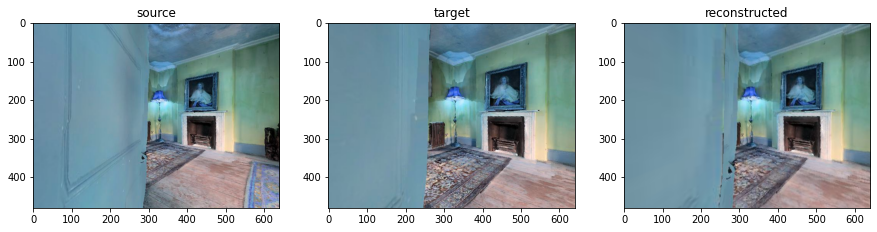

In [226]:
fig, ax = plt.subplots(ncols=3, figsize=(15,5))
ax[0].imshow(color_s)
ax[0].set_title('source')
ax[1].imshow(color_t)
ax[1].set_title('target')
ax[2].imshow(color_rc)
ax[2].set_title('reconstructed')